# YOLO Detector 로 Truck과 Bus 탐지하기

### Real-time object detection -> One-stage object detection를 선호함

### one stage detection - (shell, grid), anchor box 기반으로 동작

### backbone network를 통해 얻어진 feature map의 각 point에서 다양한 크기와 aspect ratio를 가진 box를 한칸씩 슬라이딩 시키면서 탐색 하는데 이것을 anchor box라고 한다.
 
### anchor box와 annotation 된 탐지대상의 이미지상의 실제적인 위치와의 유사성을 계산하여 적정 수준 일치하는 것만 후보군으로 추려서 탐지대상의 클래스 정보와 이미지상의 좌표 정보에 대한 예측을 한번에 detection network에서 수행하게 된다.

<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdpFHvg%2FbtqBcxhlefO%2F0v4PJtYiUjkq9ND0NmMNj1%2Fimg.png">

##  YOLOv1 detector - shell 사용
## YOLOv2부터 anchor box 사용

<img src ="https://velog.velcdn.com/images%2Fcha-suyeon%2Fpost%2F658668ea-6225-4129-99e1-cf2d1817c456%2Fimage.png">

## backbone으로부터 최종적으로 구해진 feature map 이 가지고 있는 receptive field 즉, feature map이 포함하고 있는 input image 상의 영역을 하나의 shell 혹은 grid로 두고 물체를 탐색해 나가는 방식

## 1. Bus-Truck 데이터셋 살펴보기

In [ ]:
import os
import pandas as pd
from utils import CLASS_NAME_TO_ID, visualize

In [2]:
data_dir = "../DATASET/Detection/"
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))

In [3]:
data_df

ImageID     Source LabelName  Confidence      XMin      XMax  \
0      0000599864fd15b3     xclick       Bus           1  0.343750  0.908750   
1      00006bdb1eb5cd74     xclick     Truck           1  0.276667  0.697500   
2      00006bdb1eb5cd74     xclick     Truck           1  0.702500  0.999167   
3      00010bf498b64bab     xclick       Bus           1  0.156250  0.371250   
4      00013f14dd4e168f     xclick       Bus           1  0.287500  0.999375   
...                 ...        ...       ...         ...       ...       ...   
24057  fff2b15ad6007d0e  activemil     Truck           1  0.277344  0.622656   
24058  fff376d20410e4c9     xclick       Bus           1  0.295625  0.558750   
24059  fff376d20410e4c9     xclick       Bus           1  0.348125  0.701250   
24060  fffde5953a818927     xclick       Bus           1  0.277500  0.605625   
24061  fffde5953a818927     xclick       Bus           1  0.613125  0.828750   

           YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  \
0      0.156162  0.650047           1            0  ...            0   
1      0.141604  0.437343           1            0  ...            0   
2      0.204261  0.409774           1            1  ...            0   
3      0.269188  0.705228           0            0  ...            0   
4      0.194184  0.999062           0            1  ...            0   
...         ...       ...         ...          ...  ...          ...   
24057  0.226389  0.859722           0            0  ...            0   
24058  0.306667  0.397500           1            0  ...            1   
24059  0.423333  0.744167           0            0  ...            1   
24060  0.565000  0.795833           0            0  ...            0   
24061  0.623333  0.795833           1            0  ...            0   

       IsInside  XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  \
0             0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700   
1             0  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855   
2             0  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496   
3             0  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882   
4             0  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940   
...         ...       ...       ...       ...       ...       ...       ...   
24057         0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
24058         0  0.424375  0.316250  0.295625  0.558750  0.306667  0.397500   
24059         0  0.478750  0.493125  0.348125  0.701250  0.423333  0.744167   
24060         0  0.488125  0.277500  0.517500  0.605625  0.565000  0.670000   
24061         0  0.715000  0.828750  0.710000  0.613125  0.623333  0.760833   

       XClick3Y  XClick4Y  
0      0.650047  0.457197  
1      0.352130  0.437343  
2      0.409774  0.295739  
3      0.705228  0.521691  
4      0.999062  0.523452  
...         ...       ...  
24057 -1.000000 -1.000000  
24058  0.382500  0.335833  
24059  0.537500  0.523333  
24060  0.795833  0.704167  
24061  0.795833  0.730000  

[24062 rows x 21 columns]

In [4]:
index = 0
image_files = [fn for fn in os.listdir("../DATASET/Detection/images/") if fn.endswith("jpg")]
image_file = image_files[index]
image_path = os.path.join("../DATASET/Detection/images/", image_file)

In [5]:
import cv2
import matplotlib.pyplot as plt

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

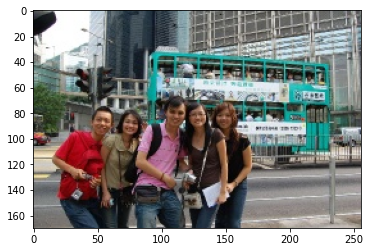

In [7]:
plt.imshow(image)

In [8]:
image_id = image_file.split('.')[0]
meta_data = data_df[data_df['ImageID'] == image_id]
cate_names = meta_data["LabelName"].values
bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values

In [9]:
cate_names

array(['Bus'], dtype=object)

In [10]:
bboxes

array([[0.34375 , 0.90875 , 0.156162, 0.650047]])

In [11]:
img_H, img_W, _ = image.shape

class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
unnorm_bboxes = bboxes.copy()
unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
unnorm_bboxes[:, [0,2]] *= img_W
unnorm_bboxes[:, [1,3]] *= img_H

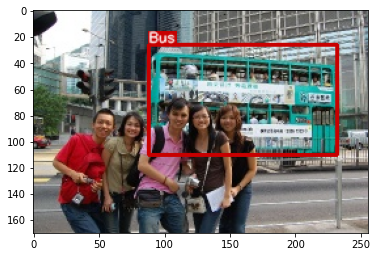

In [12]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [13]:
from ipywidgets import interact

In [14]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join("../DATASET/Detection/images/", image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data["LabelName"].values
    bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values
    
    img_H, img_W, _ = image.shape

    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
    unnorm_bboxes[:, [0,2]] *= img_W
    unnorm_bboxes[:, [1,3]] *= img_H
    canvas = visualize(image, unnorm_bboxes, class_ids)
    
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=15224), Output()), _dom_classes=('widget-int…

## 2. Object detection 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [15]:
import torch
import numpy as np

In [16]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith("jpg")]
        self.transformer = transformer
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        #image , class_id, bbox(xc,yc,w,h)
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        
        if self.transformer: 
            transformed_data = self.transformer(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])
        
        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, filename
    
    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    
    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = self.data_df[self.data_df['ImageID'] == image_id]
        cate_names = meta_data["LabelName"].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])
        bboxes = meta_data[["XMin", "XMax", "YMin", "YMax"]].values
        bboxes[:, [1,2]] = bboxes[:, [2,1]]
        bboxes[:, 2:4] -= bboxes[:, 0:2]
        bboxes[:, 0:2] += (bboxes[:, 2:4] / 2)
        return bboxes, class_ids

In [17]:
data_dir = "../DATASET/Detection/"
dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=None)

In [18]:
dataset[0]

(array([[[ 80,  87,  80],
         [ 86,  93,  86],
         [ 93,  95,  94],
         ...,
         [ 93,  91,  94],
         [ 77,  78,  82],
         [121, 125, 128]],
 
        [[ 79,  83,  82],
         [ 76,  80,  79],
         [ 79,  83,  84],
         ...,
         [ 82,  80,  83],
         [ 92,  93,  95],
         [121, 125, 126]],
 
        [[ 74,  74,  82],
         [ 68,  71,  78],
         [ 71,  74,  79],
         ...,
         [ 85,  83,  84],
         [ 98, 100,  99],
         [116, 122, 120]],
 
        ...,
 
        [[106, 102,  99],
         [108, 104, 101],
         [108, 104, 101],
         ...,
         [165, 157, 144],
         [150, 142, 129],
         [133, 125, 112]],
 
        [[108, 103,  99],
         [103,  98,  94],
         [111, 108, 103],
         ...,
         [166, 160, 148],
         [160, 154, 142],
         [151, 145, 133]],
 
        [[117, 112, 108],
         [116, 111, 107],
         [122, 119, 114],
         ...,
         [173, 167, 155],
  

In [19]:
index = 0
image, target, filename = dataset[index]
img_H, img_W, _ = image.shape

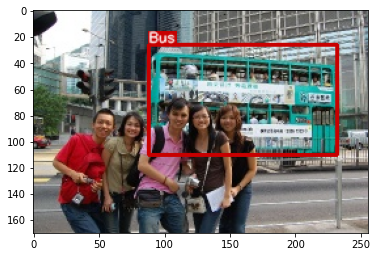

In [20]:
bboxes = target[:, 0:4]
class_ids = target[:, 4]
bboxes[:, [0,2]] *= img_W
bboxes[:, [1,3]] *= img_H

canvas = visualize(image, bboxes, class_ids)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [21]:
@interact(index=(0, len(dataset)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    img_H, img_W, _ = image.shape

    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0,2]] *= img_W
    bboxes[:, [1,3]] *= img_H

    canvas = visualize(image, bboxes, class_ids)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [23]:
IMAGE_SIZE = 448

transformer = A.Compose([
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']),
)

data_dir = "../DATASET/Detection/"
transformed_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)

In [24]:
from torchvision.utils import make_grid

In [25]:
@interact(index=(0, len(transformed_dataset)-1))
def show_sample(index=0):
    image, target, filename = transformed_dataset[index]
    _, img_H, img_W = image.shape
    print(image.shape)
    
    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    bboxes[:, [0,2]] *= img_W
    bboxes[:, [1,3]] *= img_H
    
    np_image = make_grid(image, normalize=True).cpu().permute(1,2,0).numpy()
    canvas = visualize(np_image, bboxes, class_ids)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [26]:
import torch

In [27]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    
    for a,b,c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return torch.stack(image_list, dim=0), target_list, filename_list

In [28]:
from torch.utils.data import DataLoader

In [29]:
data_dir = "../DATASET/Detection/"
BATCH_SIZE = 1

trainset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [30]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    
    if index == 0:
        break

In [31]:
def build_dataloader(data_dir, batch_size=4):
    transformer = A.Compose([
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']),
    )
    
    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = Detection_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [32]:
data_dir = "../DATASET/Detection/"
BATCH_SIZE = 2
dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)

In [33]:
for phase in ["train", "val"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(images.shape)
        print(targets)
        if index == 0:
            break

torch.Size([2, 3, 448, 448])
[array([[0.4828125, 0.480655 , 0.720625 , 0.780754 , 0.       ]]), array([[0.103125, 0.480729, 0.1375  , 0.105208, 1.      ]])]
torch.Size([1, 3, 448, 448])
[array([[0.4290625, 0.6477485, 0.496875 , 0.462477 , 1.       ]])]


## 3. YOLOv1 아키텍처 구현해보기

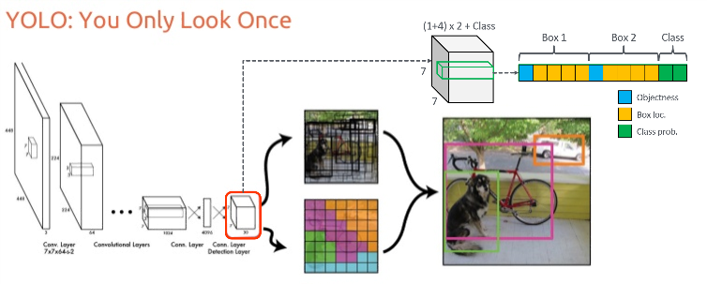

In [34]:
import torchvision
import torch.nn as nn

In [35]:
class YOLOv1_RESNET(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        num_classes = num_classes
        num_bboxes = 2
        grid_size = 7
        
        resnet18 = torchvision.models.resnet18(pretrained=True)
        layers = [m for m in resnet18.children()]
    
        self.backbone = nn.Sequential(*layers[:-2])
        
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=1024, out_channels=(4+1)*num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),
            nn.AdaptiveAvgPool2d(output_size=(grid_size, grid_size))
        )
        
    def forward(self, x):
        out = self.backbone(x)
        out = self.head(out)
        return out

In [36]:
NUM_CLASSES = 2
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)
x = torch.randn(1, 3, 448, 448)
with torch.no_grad():
    y = model(x)
print(y.shape)

torch.Size([1, 12, 7, 7])


In [37]:
data_dir = "../DATASET/Detection/"
BATCH_SIZE = 2

trainset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)

for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]
    
    predictions = model(images)
    
    if index == 0:
        break

In [38]:
predictions

tensor([[[[ 2.8050e-01, -2.3251e-01, -2.2983e-02,  ...,  2.2185e-01,
            2.0498e-01, -1.0305e-01],
          [ 8.3869e-02, -1.3230e-01,  1.1734e-01,  ...,  3.8111e-02,
            1.6897e-01,  9.2718e-02],
          [ 1.8320e-01,  1.2238e-02,  1.7121e-01,  ...,  5.2660e-01,
            9.7865e-02, -6.2294e-02],
          ...,
          [-7.4905e-02,  4.3960e-01,  5.7686e-01,  ...,  3.4731e-01,
            2.6534e-01,  1.4645e-01],
          [ 3.3056e-01,  2.1340e-01,  3.6718e-01,  ..., -1.3728e-01,
            6.4608e-02,  9.2108e-02],
          [ 1.6844e-01,  3.9865e-02,  1.0966e-01,  ..., -8.4479e-02,
            1.5243e-02, -8.2131e-02]],

         [[-2.0832e-01, -3.5027e-01, -2.4401e-01,  ..., -3.6861e-01,
            7.2922e-02, -1.7542e-01],
          [-4.7282e-01, -1.3668e-01, -3.5470e-01,  ..., -1.7485e-01,
           -3.7673e-01, -1.4913e-01],
          [-3.1549e-01, -4.4625e-01,  1.6594e-01,  ..., -1.7772e-01,
            2.3389e-02,  1.5669e-01],
          ...,
     

In [39]:
print(predictions.shape)

torch.Size([2, 12, 7, 7])


## 4. YOLOv1 Loss function 소개 및 구현해보기

Loss Funtion
1. target
[n* [x_center, y_center, width, height, class_id]]
2. network model output
448 * 448 * 3 크기의 input 값 입력 -> 7 * 7 * 12 크기의 output feature
12 = (1+4)+(1+4)+2

In [ ]:
def build_target_grid(target):
    # target -> 7 * 7 * 7 matrix 포맷으로 변경
    #7 = (1+4)+2
    # truck :0, bus:1
    #[1, xc, yc, w, h, 1, 0] = truck
    #[1, xc, yc, w, h, 0, 1] = bus
    #xc, yc, w, h -> image shape로 나눠진 소숫점을 갖고 있다.
    # 7(grid_size) * 7(grid_size) * 7(depth(objectness + bbox + class probability(클래스의 조건부 확률값으로 objectness와 곱연산을 수행해서 최종적인 probability를 결정짓는다.))
    # (C,H,W)이므로 -> (depth, grid_size, grid_size)
    target_grid = torch.zeros((1+4+num_classes, grid_size, grid_size), device=device)

    for gt in target: # target shape -> (C, H, W)
        xc, yc, w, h, cls_id = gt
        xn = (xc % (1/grid_size)) # normalize화된 gridsize와 xc로 나눈 몫으로 xc가 0에서 얼마나 떨어져있는지 계산
        yn = (yc % (1/grid_size))
        cls_id = int(cls_id)

        i_grid = int(xc * grid_size) #0~7 사이 index 구함
        j_grid = int(yc * grid_size)
        target_grid[0, j_grid, i_grid] = 1 #objectness
        target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn,yn,w,h]) #bbox
        target_grid[5+cls_id, j_grid, i_grid] = 1 #class에 대한 확률값

    return target_grid

In [83]:
def build_batch_target_grid(targets):
    target_grid_batch = torch.stack([build_target_grid(target) for target in targets], dim=0)
     # [[xc,yc,w,h], [xc,yc,w,h].....[xc,yc,w,h]]
     # target_grid_batch shape : (B, 7, 7, 7)
    return target_grid_batch

In [84]:
num_classes = 2
grid_size = 7
num_classes = 2
lambda_coord=5.
lambda_noobj=0.5

device = 'cpu'

In [85]:
groundtruths = build_batch_target_grid(targets)

In [86]:
groundtruths

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0548, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0

In [87]:
groundtruths.shape

torch.Size([2, 7, 7, 7])

-IoU 구하기
- xn, yn, w, h -> xmin, ymin, xmax, ymax 바꿔서 -> 겹쳐지는 영역의 비율을 계산
- 1. xywh -> xyxy포맷으로 변경
- 2. 교집합과 합집합의 영역을 구해야함
- 3. 교집합 비율을 구해야함

In [88]:
def generate_xy_normed_grid(grid_size):
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    xy_grid = torch.stack([x_offset, y_offset], dim=0)
    xy_normed_grid = xy_grid / grid_size
    return xy_normed_grid

In [89]:
def xywh_to_xyxy(bboxes):
    # bboxes : [xn, yn, w, h] -> offset을 다시 xc, yc, w, h로 복구
    # 복구된 영역을 기준으로 xmin, ymin,w,h 형식으로 변경
    num_batch, _, grid_size, grid_size = bboxes.shape
    xy_normed_grid = generate_xy_normed_grid(grid_size=grid_size)
    xcyc = bboxes[:,0:2,...] + xy_normed_grid.tile(num_batch, 1,1,1)
    wh = bboxes[:,2:4,...]
    x1y1 = xcyc - (wh/2)
    x2y2 = xcyc + (wh/2)
    return torch.cat([x1y1,x2y2], dim=1)

In [90]:
def get_IoU(cbox1, cbox2):
    box1 = xywh_to_xyxy(cbox1)
    box2 = xywh_to_xyxy(cbox2)

#교집합 영역 구하기
    x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
    y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
    x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
    y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

    intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
    # clamp(min=0) 두개의 값을 뺀 값이 음수가 나오는것을 방지
    union = abs(cbox1[:, 2, ...]*cbox1[:, 3, ...]) + \
            abs(cbox2[:, 2, ...]*cbox2[:, 3, ...]) - intersection

    intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
    # 7 * 7 * 7 dimension shape 보존하면서 iou 값을 반환
    return intersection

In [91]:
mse_loss = nn.MSELoss(reduction="sum")

In [92]:
iou1 = get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
iou2 = get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])

In [93]:
ious = torch.stack([iou1, iou2], dim=1)
# ious.shape(B, Box iou , grid, grid)
max_iou, best_box = ious.max(dim=1, keepdim=True)
max_iou = torch.cat([max_iou, max_iou], dim=1)
# max_iou 값의 비율이 gt값에 곱해져야 하기 때문에 prediction 후보군 수=2 만큼
# 복사를 해서 넣어주어야 한다.
best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

In [94]:
#(B , 10, 7, 7) -> (B, 2, 5, 7, 7) 
predictions_ = predictions[:, :5*2, ...].reshape(BATCH_SIZE, 2, 5, grid_size, grid_size)

obj_pred = predictions_[:, :, 0, ...]
xy_pred = predictions_[:, :, 1:3, ...]
wh_pred = predictions_[:, :, 3:5, ...]
cls_pred = predictions[:, 5*2:, ...]

In [95]:
groundtruths_ = groundtruths[:, :5, ...].reshape(BATCH_SIZE, 1, 5, grid_size, grid_size)
obj_target = groundtruths_[:, :, 0, ...]
xy_target = groundtruths_[:, :, 1:3, ...]
wh_target= groundtruths_[:, :, 3:5, ...]
cls_target = groundtruths[:, 5:, ...]

In [96]:
positive = obj_target * best_box

In [97]:
obj_loss = mse_loss(positive * obj_pred, positive * ious)
noobj_loss = mse_loss((1 - positive) * obj_pred, ious*0)
xy_loss = mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2) * xy_target)
wh_loss = mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                   positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
cls_loss = mse_loss(obj_target * cls_pred, cls_target)

In [104]:
class YOLOv1_LOSS():
    def __init__(self, num_classes, device, lambda_coord=5., lambda_noobj=0.5):
        self.num_classes = num_classes
        self.device = device
        self.grid_size = 7
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss(reduction="sum")

    def __call__(self, predictions, targets):
        self.batch_size, _, _, _ = predictions.shape
        groundtruths = self.build_batch_target_grid(targets)
        groundtruths = groundtruths.to(self.device)
        
        #iou 구하는 구간에선 꼭 no_grad 해준 상태로 진행해야한다. 
        with torch.no_grad():
            iou1 = self.get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
            iou2 = self.get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])

        ious = torch.stack([iou1, iou2], dim=1)
        max_iou, best_box = ious.max(dim=1, keepdim=True)
        max_iou = torch.cat([max_iou, max_iou], dim=1)
        best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

        predictions_ = predictions[:, :5*2, ...].reshape(self.batch_size, 2, 5, self.grid_size, self.grid_size)
        obj_pred = predictions_[:, :, 0, ...]
        xy_pred = predictions_[:, :, 1:3, ...]
        wh_pred = predictions_[:, :, 3:5, ...]
        cls_pred = predictions[:, 5*2:, ...]

        groundtruths_ = groundtruths[:, :5, ...].reshape(self.batch_size, 1, 5, self.grid_size, self.grid_size)
        obj_target = groundtruths_[:, :, 0, ...]
        xy_target = groundtruths_[:, :, 1:3, ...]
        wh_target= groundtruths_[:, :, 3:5, ...]
        cls_target = groundtruths[:, 5:, ...]
        
        positive = obj_target * best_box

        obj_loss = self.mse_loss(positive * obj_pred, positive * ious)
        noobj_loss = self.mse_loss((1 - positive) * obj_pred, ious*0)
        xy_loss = self.mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2) * xy_target)
        wh_loss = self.mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                           positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
        cls_loss = self.mse_loss(obj_target * cls_pred, cls_target)
        
        obj_loss /= self.batch_size
        noobj_loss /= self.batch_size
        bbox_loss = (xy_loss+wh_loss) / self.batch_size
        cls_loss /= self.batch_size
        
        total_loss = obj_loss + self.lambda_noobj*noobj_loss + self.lambda_coord*bbox_loss + cls_loss
        return total_loss, (obj_loss.item(), noobj_loss.item(), bbox_loss.item(), cls_loss.item())
    
    def build_target_grid(self, target):
        target_grid = torch.zeros((1+4+self.num_classes, self.grid_size, self.grid_size), device=self.device)

        for gt in target:
            xc, yc, w, h, cls_id = gt
            xn = (xc % (1/self.grid_size))
            yn = (yc % (1/self.grid_size))
            cls_id = int(cls_id)

            i_grid = int(xc * self.grid_size)
            j_grid = int(yc * self.grid_size)
            target_grid[0, j_grid, i_grid] = 1
            target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn,yn,w,h])
            target_grid[5+cls_id, j_grid, i_grid] = 1

        return target_grid
    
    def build_batch_target_grid(self, targets):
        target_grid_batch = torch.stack([self.build_target_grid(target) for target in targets], dim=0)
        return target_grid_batch
    
    def get_IoU(self, cbox1, cbox2):
        box1 = self.xywh_to_xyxy(cbox1)
        box2 = self.xywh_to_xyxy(cbox2)

        x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
        y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
        x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
        y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

        intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
        union = abs(cbox1[:, 2, ...]*cbox1[:, 3, ...]) + \
                abs(cbox2[:, 2, ...]*cbox2[:, 3, ...]) - intersection

        intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
        return intersection
    
    def generate_xy_normed_grid(self):
        y_offset, x_offset = torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size))
        xy_grid = torch.stack([x_offset, y_offset], dim=0)
        xy_normed_grid = xy_grid / self.grid_size
        return xy_normed_grid.to(self.device)

    def xywh_to_xyxy(self, bboxes):
        xy_normed_grid = self.generate_xy_normed_grid()
        xcyc = bboxes[:,0:2,...] + xy_normed_grid.tile(self.batch_size, 1,1,1)
        wh = bboxes[:,2:4,...]
        x1y1 = xcyc - (wh/2)
        x2y2 = xcyc + (wh/2)
        return torch.cat([x1y1, x2y2], dim=1)

In [105]:
data_dir = "../DATASET/Detection/"
is_cuda = False

BATCH_SIZE = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

trainset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)
criterion = YOLOv1_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4)

for index, batch in enumerate(trainloader):
    images = batch[0].to(DEVICE)
    targets = batch[1]
    filenames = batch[2]
    
    predictions = model(images)
    loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)
    
    print(loss, obj_loss, noobj_loss, bbox_loss, cls_loss)
    
    if index == 0:
        break

tensor(18.3989, grad_fn=<AddBackward0>) 0.8722705841064453 16.337358474731445 1.4378538131713867 2.1686511039733887


In [106]:
loss

tensor(18.3989, grad_fn=<AddBackward0>)

In [107]:
loss.backward()

In [109]:
data_dir = "../DATASET/Detection/"
is_cuda = False

BATCH_SIZE = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

trainset = Detection_dataset(data_dir=data_dir, phase="train", transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)
criterion = YOLOv1_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4)

for index, batch in enumerate(trainloader):
    images = batch[0].to(DEVICE)
    targets = batch[1]
    filenames = batch[2]
    
    predictions = model(images)
    loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if index % 5 == 0:
        print(loss.item(), obj_loss, noobj_loss, bbox_loss, cls_loss)
    
    if index == 20:
        break

18.913183212280273 0.3797743022441864 17.840246200561523 1.7671228647232056 0.7776721715927124
6.605963230133057 0.07983885705471039 6.000910758972168 0.5032246112823486 1.009545922279358
4.789135932922363 0.07785104960203171 4.765457630157471 0.237282395362854 1.1421443223953247
5.259491920471191 0.02133781462907791 3.850937604904175 0.3982979655265808 1.3211956024169922
9.216222763061523 0.01339931320399046 4.015976905822754 1.322831153869629 0.5806785225868225


## 5. Detector 학습을 위한 코드 작성해보기

In [110]:
from collections import defaultdict

In [111]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)
    
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        running_loss = defaultdict(float)
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1]
            filenames = batch[2]
            
            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
            loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)
  
            if phase == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss["total_loss"] += loss.item()
                running_loss["obj_loss"] += obj_loss
                running_loss["noobj_loss"] += noobj_loss
                running_loss["bbox_loss"] += bbox_loss
                running_loss["cls_loss"] += cls_loss
                
                train_loss["total_loss"] += loss.item()
                train_loss["obj_loss"] += obj_loss
                train_loss["noobj_loss"] += noobj_loss
                train_loss["bbox_loss"] += bbox_loss
                train_loss["cls_loss"] += cls_loss
                
                if (index > 0) and (index % VERBOSE_FREQ) == 0:
                    text = f"iteration:[{index}/{len(dataloaders[phase])}] - "
                    for k, v in running_loss.items():
                        text += f"{k}: {v/VERBOSE_FREQ:.4f}  "
                        running_loss[k] = 0.
                    print(text)
            else:
                val_loss["total_loss"] += loss.item()
                val_loss["obj_loss"] += obj_loss
                val_loss["noobj_loss"] += noobj_loss
                val_loss["bbox_loss"] += bbox_loss
                val_loss["cls_loss"] += cls_loss

    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders["train"])
        val_loss[k] /= len(dataloaders["val"])
    return train_loss, val_loss

In [112]:
from utils import save_model

In [114]:
data_dir = "../DATASET/Detection/"
is_cuda = True

NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 12
VERBOSE_FREQ = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = YOLOv1_LOSS(num_classes=NUM_CLASSES, device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [115]:
num_epochs = 100

best_epoch = 0
best_score = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"epoch:{epoch+1}/{num_epochs} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
    
    if (epoch+1) % 10 == 0:
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

iteration:[100/1142] - total_loss: 15.0359  obj_loss: 0.1665  noobj_loss: 8.4924  bbox_loss: 1.9009  cls_loss: 1.1187  
iteration:[200/1142] - total_loss: 2.1985  obj_loss: 0.1694  noobj_loss: 0.4950  bbox_loss: 0.1992  cls_loss: 0.7857  
iteration:[300/1142] - total_loss: 1.9893  obj_loss: 0.2040  noobj_loss: 0.3039  bbox_loss: 0.1745  cls_loss: 0.7607  


KeyboardInterrupt: 

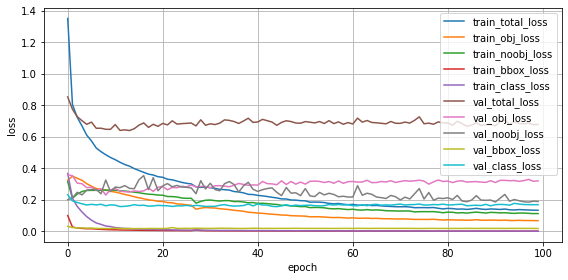

## 6. Confidence threshold 와 Non-maximum suppression(NMS) 소개와 적용해보기

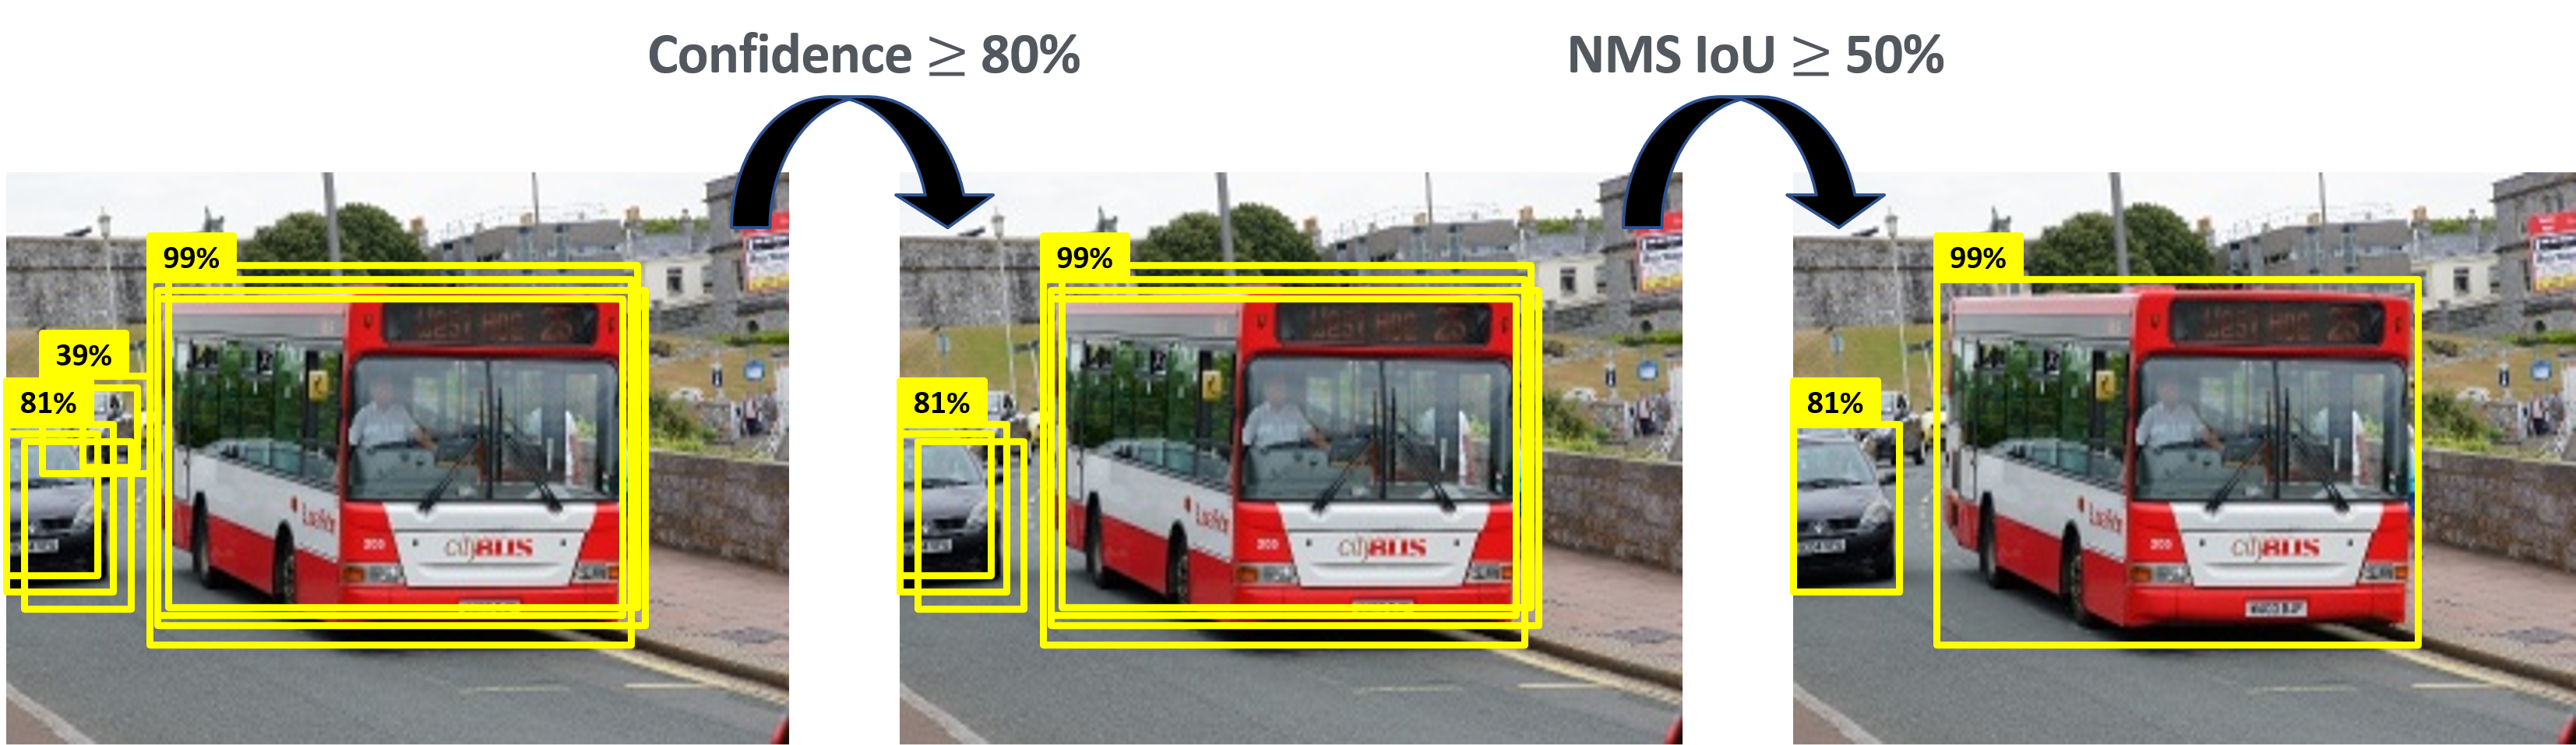

In [40]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = YOLOv1_RESNET(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [41]:
transformer = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

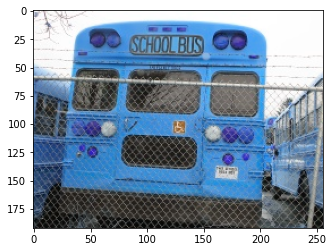

In [42]:
ckpt_path = "./trained_model/model_100.pth"
device = torch.device("cpu")
model = load_model(ckpt_path, NUM_CLASSES, device)

image = cv2.imread("../DATASET/Detection/val/e512e8e7986a9a0f.jpg")
plt.imshow(image)

In [43]:
transformed_data = transformer(image=image)
with torch.no_grad():
    predictions = model(transformed_data['image'].unsqueeze(dim=0))
prediction = predictions.detach().cpu().squeeze(dim=0)

In [44]:
grid_size = prediction.shape[-1]
y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
stride_size = IMAGE_SIZE/grid_size

conf = prediction[[0,5], ...].reshape(1, -1)
xc = (prediction[[1,6], ...] * IMAGE_SIZE + x_grid*stride_size).reshape(1,-1)
yc = (prediction[[2,7], ...] * IMAGE_SIZE + y_grid*stride_size).reshape(1,-1)
w = (prediction[[3,8], ...] * IMAGE_SIZE).reshape(1,-1)
h = (prediction[[4,9], ...] * IMAGE_SIZE).reshape(1,-1)
cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1,2)

x_min = xc - w/2
y_min = yc - h/2
x_max = xc + w/2
y_max = yc + h/2

prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
prediction_res = prediction_res.transpose(0,1)

# NMS 사용을 위해 x_min, y_min, x_max, y_max 형태로 변환해야 함 

In [45]:
conf_thres = 0.3
pred_res = prediction_res[prediction_res[:, 4] > conf_thres]

In [46]:
iou_threshold = 0.1
nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
pred_res_ = pred_res[nms_index].numpy()

In [47]:
pred_res_

array([[1.6075348e+01, 3.8643173e+01, 3.9078870e+02, 4.2435504e+02,
        3.7797704e-01, 0.0000000e+00]], dtype=float32)

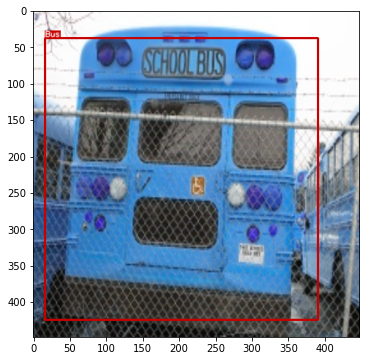

In [48]:
import numpy as np

image = cv2.resize(image, dsize=(IMAGE_SIZE, IMAGE_SIZE))

n_obj = pred_res_.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
class_ids = pred_res_[:, 5]

canvas = visualize(image, bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

In [49]:
ckpt_path = "./trained_model/model_100.pth"

DEVICE = torch.device("cuda")
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)

In [50]:
image = cv2.imread("../DATASET/Detection/val/e512e8e7986a9a0f.jpg")

In [51]:
image.shape

(192, 256, 3)

In [52]:
@torch.no_grad()
def model_predict(image, model, conf_thres=0.3, iou_threshold=0.1):
    predictions = model(image)
    prediction = predictions.detach().cpu().squeeze(dim=0)
    
    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE/grid_size

    conf = prediction[[0,5], ...].reshape(1, -1)
    xc = (prediction[[1,6], ...] * IMAGE_SIZE + x_grid*stride_size).reshape(1,-1)
    yc = (prediction[[2,7], ...] * IMAGE_SIZE + y_grid*stride_size).reshape(1,-1)
    w = (prediction[[3,8], ...] * IMAGE_SIZE).reshape(1,-1)
    h = (prediction[[4,9], ...] * IMAGE_SIZE).reshape(1,-1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1,2)
    
    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0,1)

    prediction_res[:, 2].clip(min=0, max=image.shape[1])
    prediction_res[:, 3].clip(min=0, max=image.shape[0])
        
    pred_res = prediction_res[prediction_res[:, 4] > conf_thres]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()
    
    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]
    
    return bboxes, scores, class_ids

In [53]:
from torchvision.utils import make_grid

In [54]:
pred_images = []
pred_labels =[]

for index, batch in enumerate(dataloaders["val"]):
    images = batch[0].to(DEVICE)
    bboxes, scores, class_ids = model_predict(images, model, conf_thres=0.2, iou_threshold=0.1)
    
    if len(bboxes) > 0:
        prediction_yolo = np.concatenate([bboxes, scores[:, np.newaxis], class_ids[:, np.newaxis]], axis=1)
    else:
        prediction_yolo = np.array([])
        
    np_image = make_grid(images[0], normalize=True).cpu().permute(1,2,0).numpy()
    pred_images.append(np_image)
    pred_labels.append(prediction_yolo)

In [55]:
from ipywidgets import interact

@interact(index=(0,len(pred_images)-1))
def show_result(index=0):
    if len(pred_labels[index]) > 0:
        result = visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 5])
    else:
        result = pred_images[index]
        
    plt.figure(figsize=(6,6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=1521), Output()), _dom_classes=('widget-inte…

## 7. 탐지성능검증을 위한 지표 소개 및 적용해보기

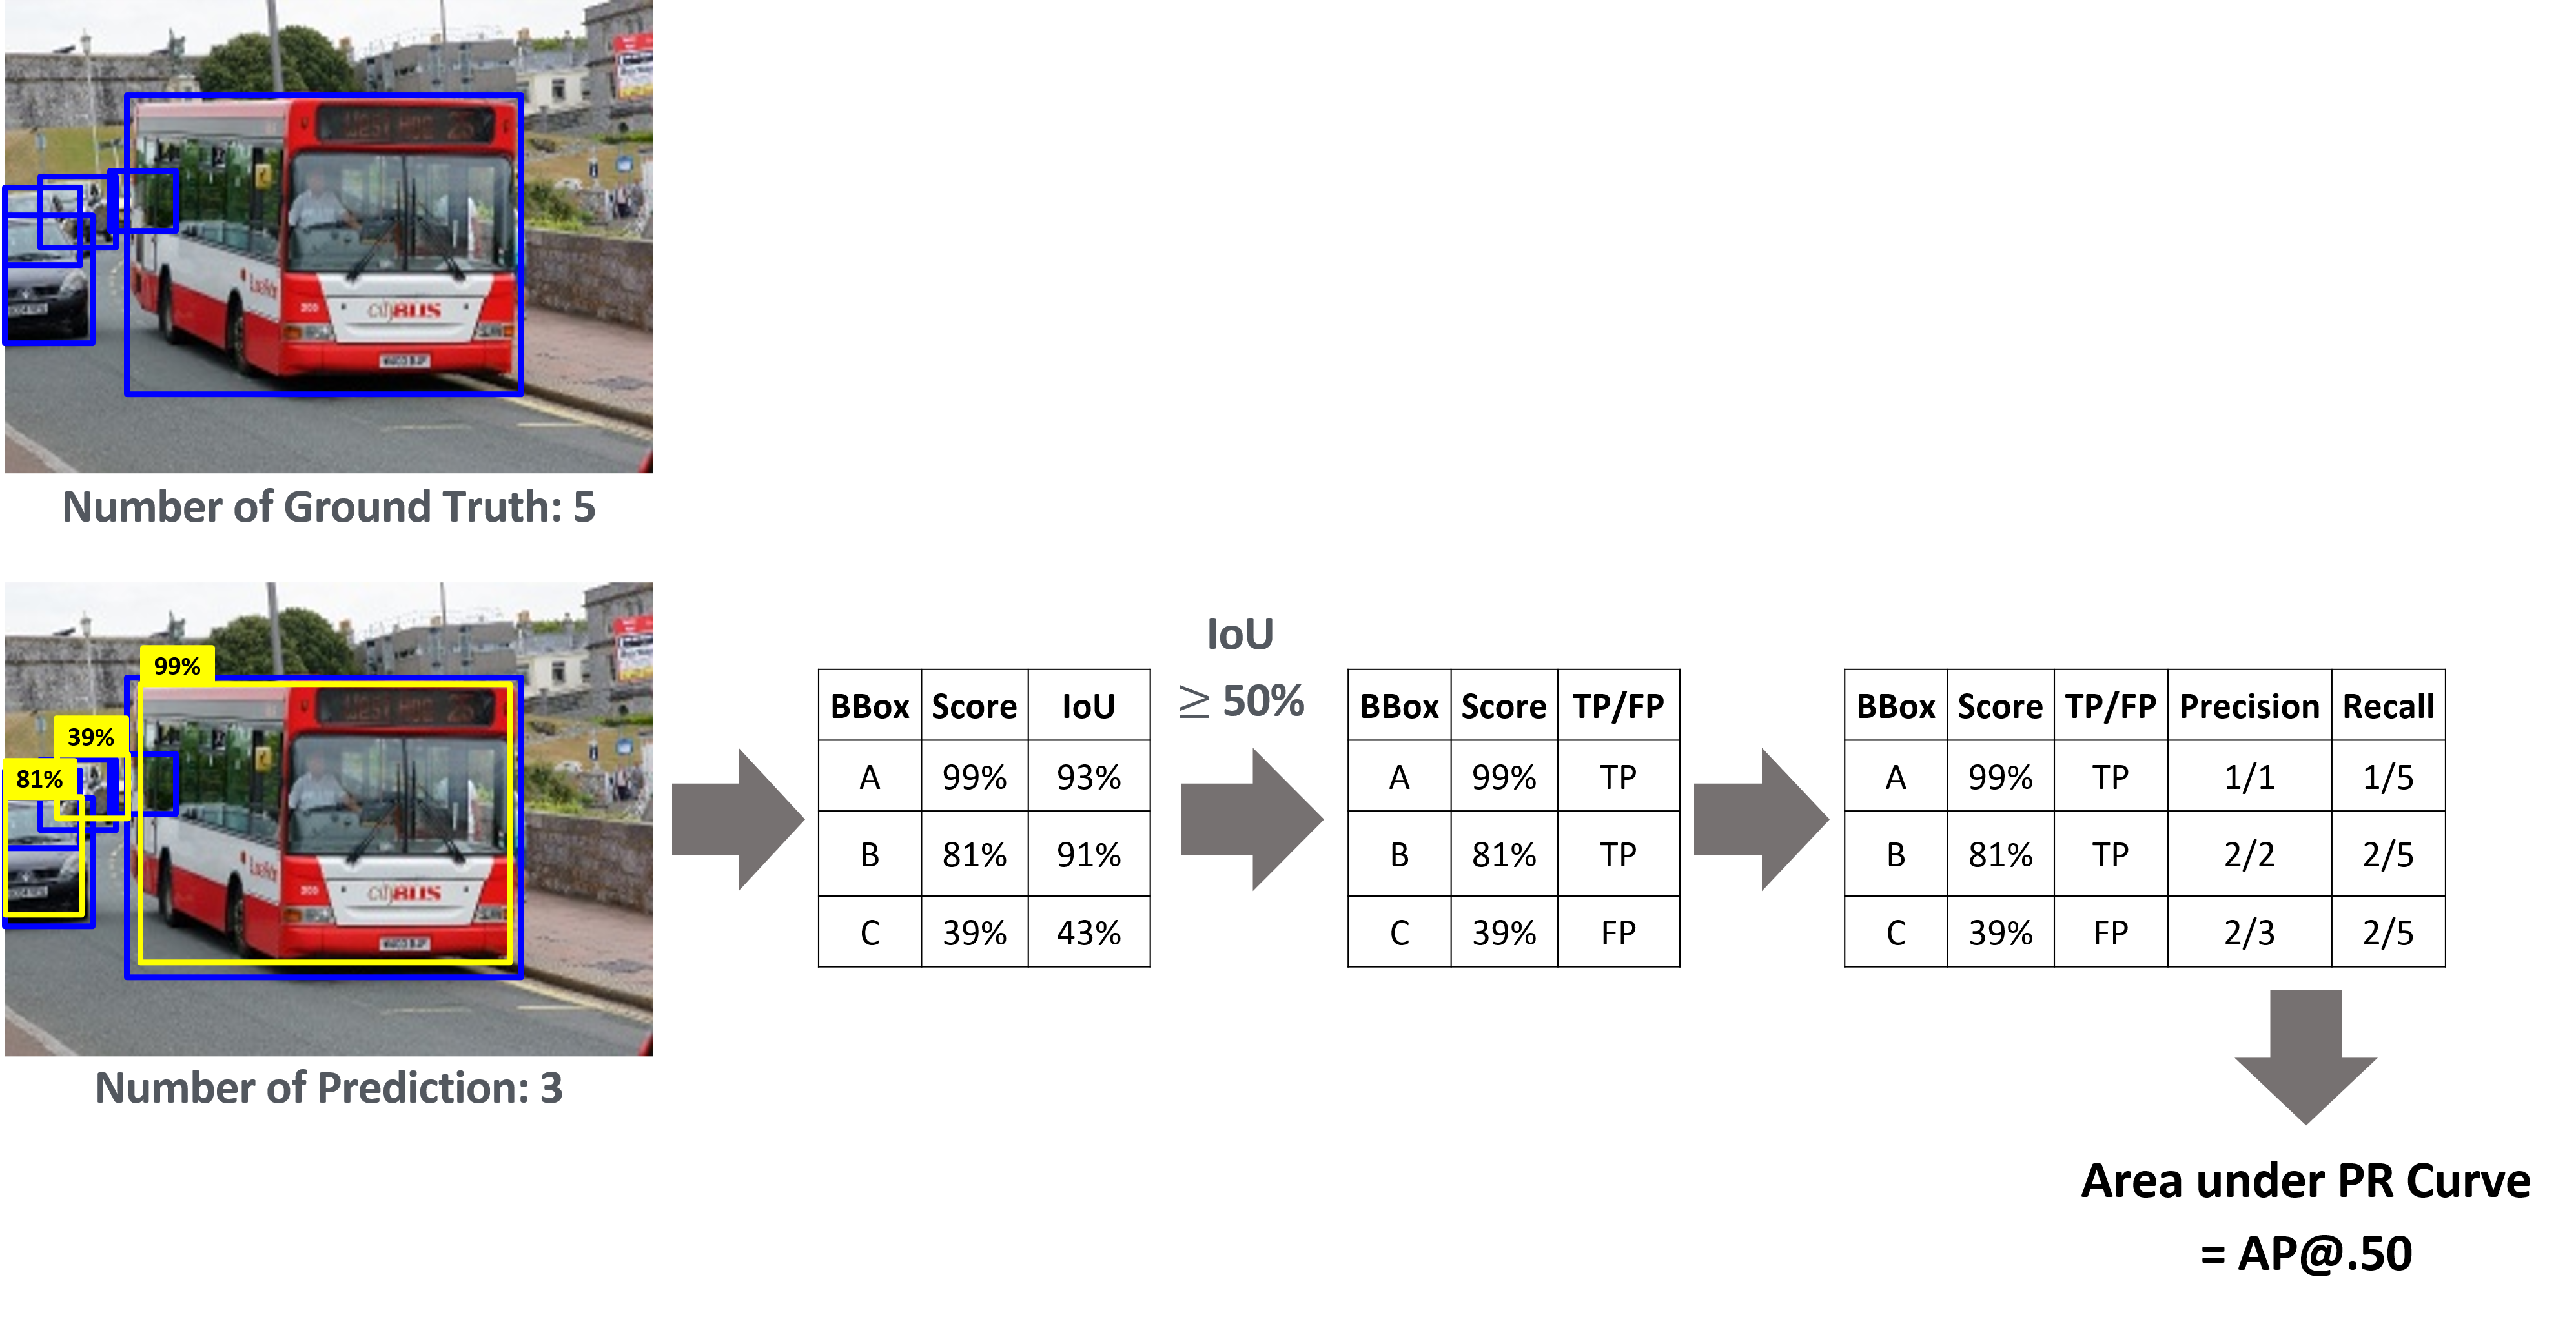

In [56]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [57]:
annFile = "../DATASET/Detection/val.json"
with open(annFile, mode='r') as f:
    json_data = json.load(f)
imageToid = json_data["imageToid"]
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [58]:
def XcenYcenWH_to_XminYmin_WH(box):
    Xmin = box[:, 0] - box[:, 2]/2
    Ymin = box[:, 1] - box[:, 3]/2
    W = box[:, 2]
    H = box[:, 3]
    return np.stack((Xmin, Ymin, W, H), axis=1)

In [59]:
COCO_anno = []

for index, batch in enumerate(dataloaders["val"]):
    images = batch[0].to(DEVICE)
    filename = batch[2][0]
    
    bboxes, scores, class_ids = model_predict(images, model, conf_thres=0.1, iou_threshold=0.1)
    box_xywh = XcenYcenWH_to_XminYmin_WH(bboxes)
    score = scores[:, np.newaxis]
    cls_id = class_ids[:, np.newaxis]
    
    img_id = np.array([imageToid[filename], ] * len(cls_id))[:, np.newaxis]
    COCO_anno.append(np.concatenate((img_id, box_xywh, score, cls_id), axis=1))
    
    if index % 50 == 0:
        print(f"{index}/{len(dataloaders['val'])} Done.")

COCO_anno = np.concatenate(COCO_anno, axis=0)

0/1522 Done.
50/1522 Done.
100/1522 Done.
150/1522 Done.
200/1522 Done.
250/1522 Done.
300/1522 Done.
350/1522 Done.
400/1522 Done.
450/1522 Done.
500/1522 Done.
550/1522 Done.
600/1522 Done.
650/1522 Done.
700/1522 Done.
750/1522 Done.
800/1522 Done.
850/1522 Done.
900/1522 Done.
950/1522 Done.
1000/1522 Done.
1050/1522 Done.
1100/1522 Done.
1150/1522 Done.
1200/1522 Done.
1250/1522 Done.
1300/1522 Done.
1350/1522 Done.
1400/1522 Done.
1450/1522 Done.
1500/1522 Done.


In [60]:
cocoDt = cocoGt.loadRes(COCO_anno)

Loading and preparing results...
Converting ndarray to lists...
(2331, 7)
0/2331
DONE (t=0.01s)
creating index...
index created!


In [61]:
annType = "bbox"
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.areaRng = [[0, 1e+8], [0, 20**2], [20**2, 100**2], [100**2, 1e+8]]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()
eval_stats = cocoEval.stats

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

## 8. YOLOv1 모델 테스트해보기

In [78]:
transformer = A.Compose([
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2()
])

In [84]:
tf_data = transformer(image=image)

In [85]:
tf_data

{'image': tensor([[[-0.0458, -0.5253, -0.6794,  ..., -0.3712, -0.5424, -0.5767],
          [ 0.1426, -0.4568, -0.5767,  ..., -0.4397, -0.5767, -0.7137],
          [ 0.0569, -0.4568, -0.6281,  ..., -0.4397, -0.4397, -0.4911],
          ...,
          [ 0.4337,  0.4337,  0.4337,  ..., -0.1999,  0.4166,  0.3652],
          [ 0.4508,  0.4508,  0.4508,  ...,  0.1768,  0.3994, -0.0629],
          [ 0.4851,  0.4679,  0.4679,  ...,  0.3481,  0.4851, -0.7479]],
 
         [[ 0.1001, -0.3901, -0.5476,  ..., -0.2150, -0.3725, -0.4251],
          [ 0.2927, -0.3200, -0.4426,  ..., -0.2850, -0.4251, -0.5651],
          [ 0.2052, -0.3200, -0.4951,  ..., -0.2850, -0.2850, -0.3375],
          ...,
          [ 0.6429,  0.6429,  0.6429,  ..., -0.1275,  0.5203,  0.4678],
          [ 0.6604,  0.6604,  0.6604,  ...,  0.2752,  0.5028,  0.0301],
          [ 0.6954,  0.6779,  0.6779,  ...,  0.4328,  0.5903, -0.6702]],
 
         [[ 0.0082, -0.4798, -0.6367,  ..., -0.2707, -0.4450, -0.4798],
          [ 0.1999,

In [146]:
@torch.no_grad()
def model_predict(image, model, conf_thres=0.3, iou_threshold=0.1):
    tf_data = transformer(image=image)
    tensor_image = tf_data['image'].to(DEVICE)
    tensor_image = tensor_image.unsqueeze(dim=0)
    
    predictions = model(tensor_image)
    prediction = predictions.detach().cpu().squeeze(dim=0)

    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE/grid_size

    conf = prediction[[0,5], ...].reshape(1, -1)
    xc = (prediction[[1,6], ...] * IMAGE_SIZE + x_grid*stride_size).reshape(1,-1)
    yc = (prediction[[2,7], ...] * IMAGE_SIZE + y_grid*stride_size).reshape(1,-1)
    w = (prediction[[3,8], ...] * IMAGE_SIZE).reshape(1,-1)
    h = (prediction[[4,9], ...] * IMAGE_SIZE).reshape(1,-1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1,2)
    
    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0,1)
        
    pred_res = prediction_res[prediction_res[:, 4] > conf_thres]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()
    
    n_obj = pred_res_.shape[0]
    bboxes = pred_res_[:, 0:4]
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]
    
    return bboxes, scores, class_ids

In [147]:
from time import time

In [140]:
video_path = "../DATASET/sample_video.mp4"

In [144]:
vid = cv2.VideoCapture(video_path)

while (vid.isOpened()):
    ret, frame = vid.read()
    
    if ret:
        since = time()
        ori_h, ori_w = frame.shape[:2]
        bboxes, scores, class_ids = model_predict(frame, model, conf_thres=0.2, iou_threshold=0.1)
        text= f"{(time() - since)*1000:.0f}ms/image"
        
        if len(bboxes) > 0:
            bboxes[:, [0,2]] *= (ori_w/IMAGE_SIZE)
            bboxes[:, [1,3]] *= (ori_h/IMAGE_SIZE)
            bboxes[:, 2].clip(min=0, max=ori_w)
            bboxes[:, 3].clip(min=0, max=ori_h)
            result = visualize(frame, bboxes, class_ids)
        else:
            result = frame
            
        cv2.putText(result, text, (20, 40), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2.imshow('camera', result)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()
    
vid.release()
cv2.destroyAllWindows()